# 0.0 IMPORTS

In [1]:
import math
import pandas as pd
import inflection
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from IPython.core.display import HTML
from IPython.display import Image
import collections

import datetime

## 0.1 Helper function

In [ ]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML ('<style>.container { width:100% !important;}</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()

## 0.2 Loading data

In [2]:
# Carregando os arquivos de dados 

df_sales_raw = pd.read_csv('data/train.csv', low_memory = False)
df_store_raw = pd.read_csv('data/store.csv', low_memory = False)

# merge - Para juntar as vendas e as caracteristicas da loja em um data frame só
# pd.merge(arquivo que vai ser a referência, arquivo que vai ser anexado, lugar onde vai ser anexado, e a tabela que tem em 
#comum entre os dois arquivos)

df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on='Store') 


# 1.0 DATA DESCRIPTION

In [3]:
# Criando uma cópia de segurança caso aconteça alguma coisa

df1 = df_raw.copy()


## 1.1 Rename columns

In [4]:
# Convertento as colunas para um estilo snake_case

cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 
            'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 
            'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore (x)

cols_new = list ( map(snakecase, cols_old))
df1.columns = cols_new

## 1.2 Data Dimentions

In [5]:
print('Number of Rols {}'.format(df1.shape[0] ) )
print('Number of Cols {}'.format(df1.shape[1] ) )

Number of Rols 1017209
Number of Cols 18


## 1.3 Data types

In [6]:
# Convertendo a coluna date que esta como object para datetime
df1['date'] = pd.to_datetime(df1['date'])

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [7]:
# Eu estou contando quantas linha tem NA por coluna

df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [8]:
#competition_distance | Usando uma funcao lambda para substituir todos os valores NA por 200.000 pois é um numero muito acima
#do máximo da coluna
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month 
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1 )
                       
#promo2_since_week      

df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1 )


#promo2_since_year     

df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1 )


#promo_interval

month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace = True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1)

df1.sample(2)


,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
942053,664,6,2013-03-09,2777,383,1,0,0,0,d,c,1680.0,10.0,2005.0,0,10.0,2013.0,0,Mar,0
236778,473,3,2014-12-31,2561,396,1,0,0,1,a,a,50.0,12.0,2014.0,0,1.0,2014.0,0,Dec,0


## 1.6 Change types

In [9]:
# Como eu mudei as colunas de um data frame preciso ter certeza que todas as colunas estão com seus respectivos tipos

df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')

df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

## 1.7 Descriptive Statistical

### Com a estatistica descritiva eu tenho noção de como meus dados estão organizados e é daqui que começa a sair os primeiros insights para a análise de negócio

In [10]:
# Central Tendency - mean, median
# Dispersion - std, min, max, range, skew, kourtosis

In [11]:
# Separando meu dataset em variáveis numérica e variáveis categóricas
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical attributes

In [12]:
# Central Tendency - mean, median

ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis

d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min )).T
d3 = pd.DataFrame(num_attributes.apply(max )).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() )).T

# Concatenando todas medidas de disperção numerica
numerical_metrics = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
numerical_metrics.columns = ['attributes', 'min_value', 'max_value', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

numerical_metrics

,attributes,min_value,max_value,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.2 categorical attributes

In [13]:
# Eu estou pegando os atributos categoricos únicos e contando eles

cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

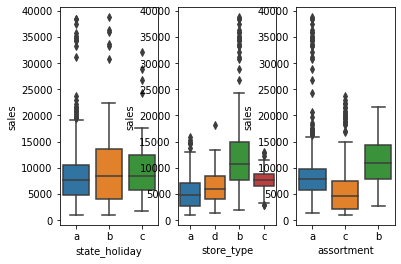

In [14]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1,3,1)
sns.boxplot(x = 'state_holiday', y = 'sales', data = aux1)

plt.subplot(1,3,2)
sns.boxplot(x = 'store_type', y = 'sales', data = aux1)

plt.subplot(1,3,3)
sns.boxplot(x = 'assortment', y = 'sales', data = aux1)

# 2.0 FEATURING ENGINEERING

In [15]:
df2 = df1.copy()

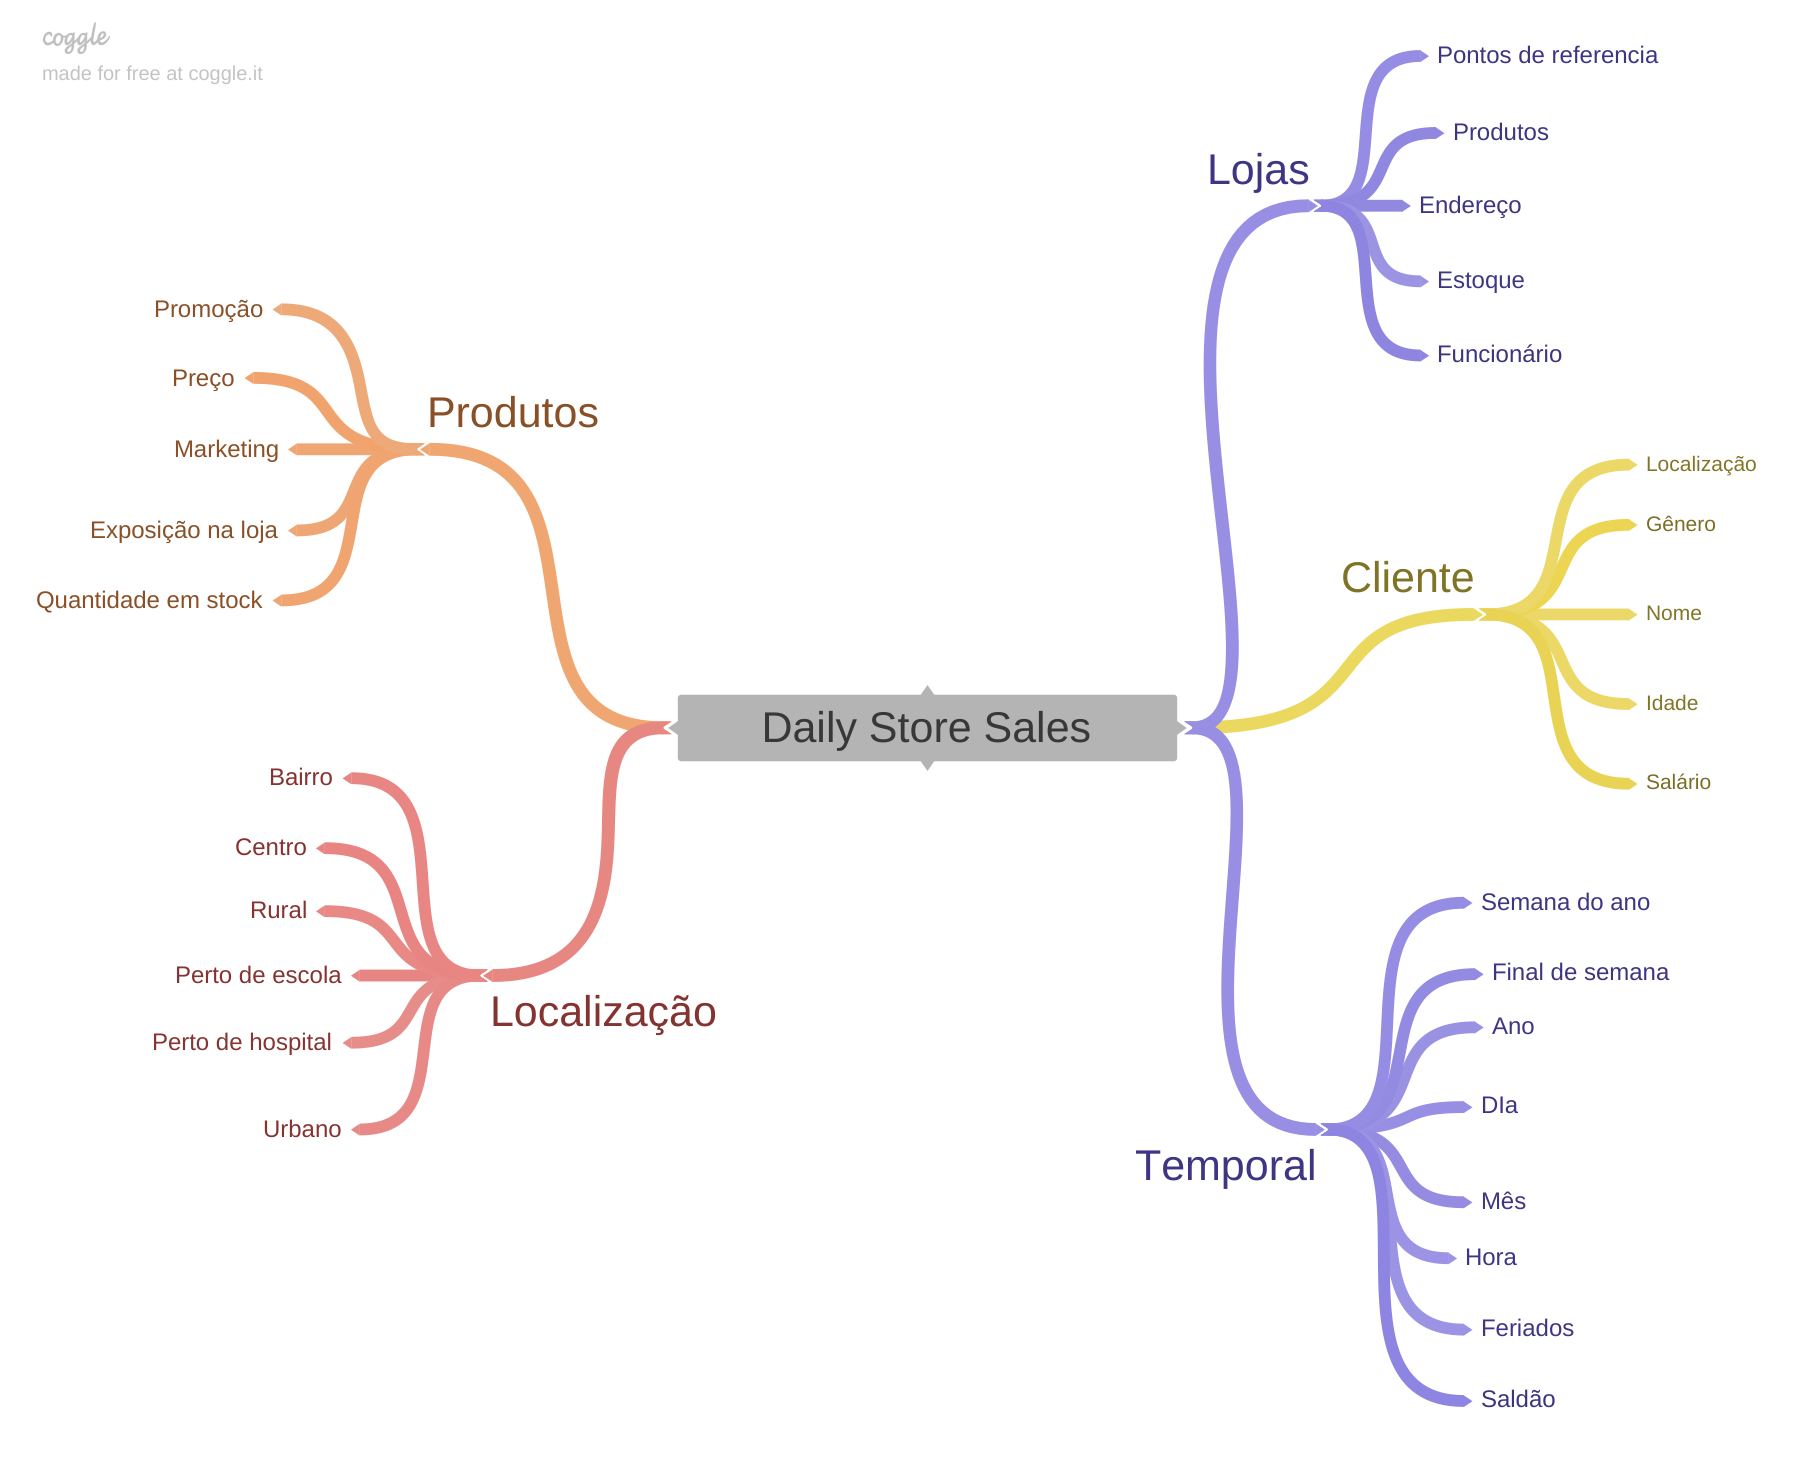

In [16]:
Image('Imagens/Daily_Store_Sales.png')

## 2.1. Criação das hipoteses

### 2.1.1 Hipótese da loja

**1.** - Lojas com número maior de funcionários deveriam vender mais

**2.** - Lojas com maior capacidade de estoque deveriam vender mais

**3.** - Lojas com maior porte deveriam vender mais

**4.** - Lojas com maior sortimentos deveriam vender mais

**5.** - Lojas com competidores mai próximos deveriam vender menos

**6.** - Lojas com competidores a mais tempo deveriam vender mais

### 2.1.2 Hipótese do produto

**1.** -Lojas que investem mais em marketing deveriam vender mais

**2.** -Lojas com maior exposiçãode produtos deveriam vender mais

**3.** -Lojas com produtos com preço menor deveriam vender mais

**4.** -Lojas com promoções mais agressivas deveriam vender mais

**5.** -Lojas com promoções ativas por mais tempo deveriam vender mais

**6.** -Lojas com mais dias de promoção deveriam vender mais

**7.** -Lojas com mais promoções consecutivas deveriam vender mais

### 2.1.3 Hipótese do tempo

**1.** - Lojas abertas durante o feriado de natal deveriam vender mais

**2.** - Lojas deveriam vender mais ao longo dos anos

**3.** - Lojas deveriam vender mais no segundo semestre do ano

**4.** - Lojas deveriam vender mais depois do dia 10 de casa mês

**5.** - Lojas deveriam vender menos ao dinais de semana

**6.** - Lojas deveriam vender menos durante os feriados escolares

## 2.2 Lista de hipóteses

**1.** - Lojas com maior sortimentos deveriam vender mais

**2.** - Lojas com competidores mai próximos deveriam vender menos

**3.** - Lojas com competidores a mais tempo deveriam vender mais

**4.** -Lojas com promoções ativas por mais tempo deveriam vender mais

**5.** -Lojas com mais dias de promoção deveriam vender mais

**6.** -Lojas com mais promoções consecutivas deveriam vender mais

**7.** - Lojas abertas durante o feriado de natal deveriam vender mais

**8.** - Lojas deveriam vender mais ao longo dos anos

**9.** - Lojas deveriam vender mais no segundo semestre do ano

**10.** - Lojas deveriam vender mais depois do dia 10 de casa mês

**11.** - Lojas deveriam vender menos ao dinais de semana

**6.** - Lojas deveriam vender menos durante os feriados escolares

## 2.3 Feature Engineering

In [17]:
# Day
df2['day'] = df2['date'].dt.day

#Week
df2['week'] = df2['date'].dt.week

# Month
df2['month'] = df2['date'].dt.month

# Year
df2['year'] = df2['date'].dt.year

# Week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# Year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# Competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year= x['competition_open_since_year'], month= x['competition_open_since_month'], day=1), axis=1)
df2['competition_since_month'] = ((df2['date'] - df2['competition_since']) /30).apply(lambda x: x.days).astype('int64')

# Promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w' ) - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype('int64')

#assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extended')



<ipython-input-17-138a5413cc45>:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['week'] = df2['date'].dt.week
<ipython-input-17-138a5413cc45>:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


In [18]:
# state_holiday
#a = public holiday, b = Easter holiday, c = Christmas
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public holiday' if x == 'a' else 'Easter holiday' if x =='b' else 'Christmas' if x == 'c' else 'regular day')

In [19]:
df2['state_holiday'].sample(10)

806361    regular day
312353    regular day
588447    regular day
852106    regular day
416062    regular day
813568    regular day
183472    regular day
725833    regular day
337908    regular day
710792    regular day
Name: state_holiday, dtype: object

# 3.0 FILTRAGEM DE VARIAVEIS

In [20]:
df3 = df2.copy()

## 3.1 Filtragem das linhas

In [21]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

In [22]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,day,week,month,year,week_of_year,year_week,competition_since,competition_since_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular day,1,c,...,31,31,7,2015,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular day,1,a,...,31,31,7,2015,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular day,1,a,...,31,31,7,2015,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular day,1,c,...,31,31,7,2015,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular day,1,a,...,31,31,7,2015,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.2 Seleção das colunas

In [23]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis = 1)

# 4.0 EDA - ANÁLISE EXPLORATÓRIA DE DADOS

In [24]:
df4 = df3.copy()

## 4.1 Análise Univariada

### 4.1.1 Variável Resposta

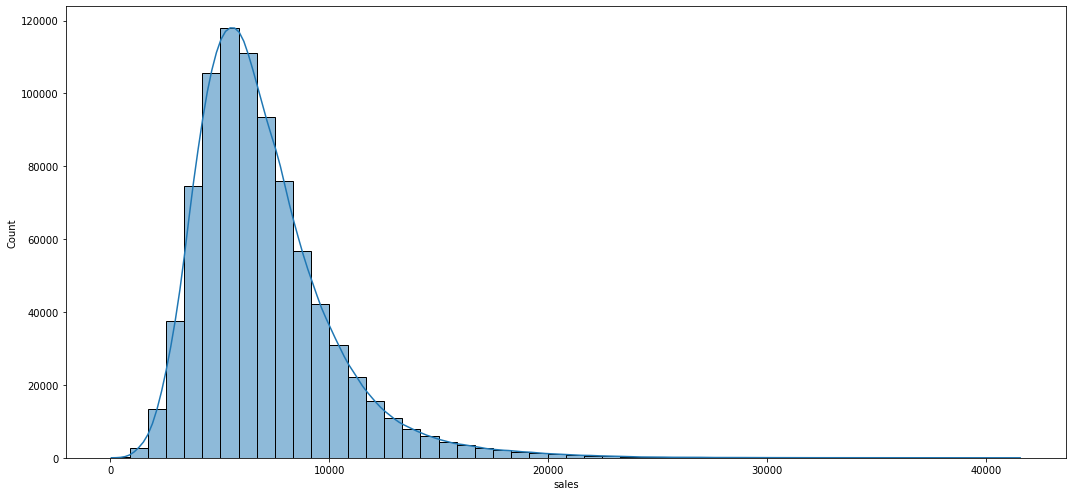

In [25]:
fig_size = (15,7)
fig,ax = plt.subplots(figsize = fig_size)
sns.histplot(ax=ax, data=df4['sales'], bins=50, kde=True)
plt.tight_layout()

### 4.1.2 Variáveis Numéricas

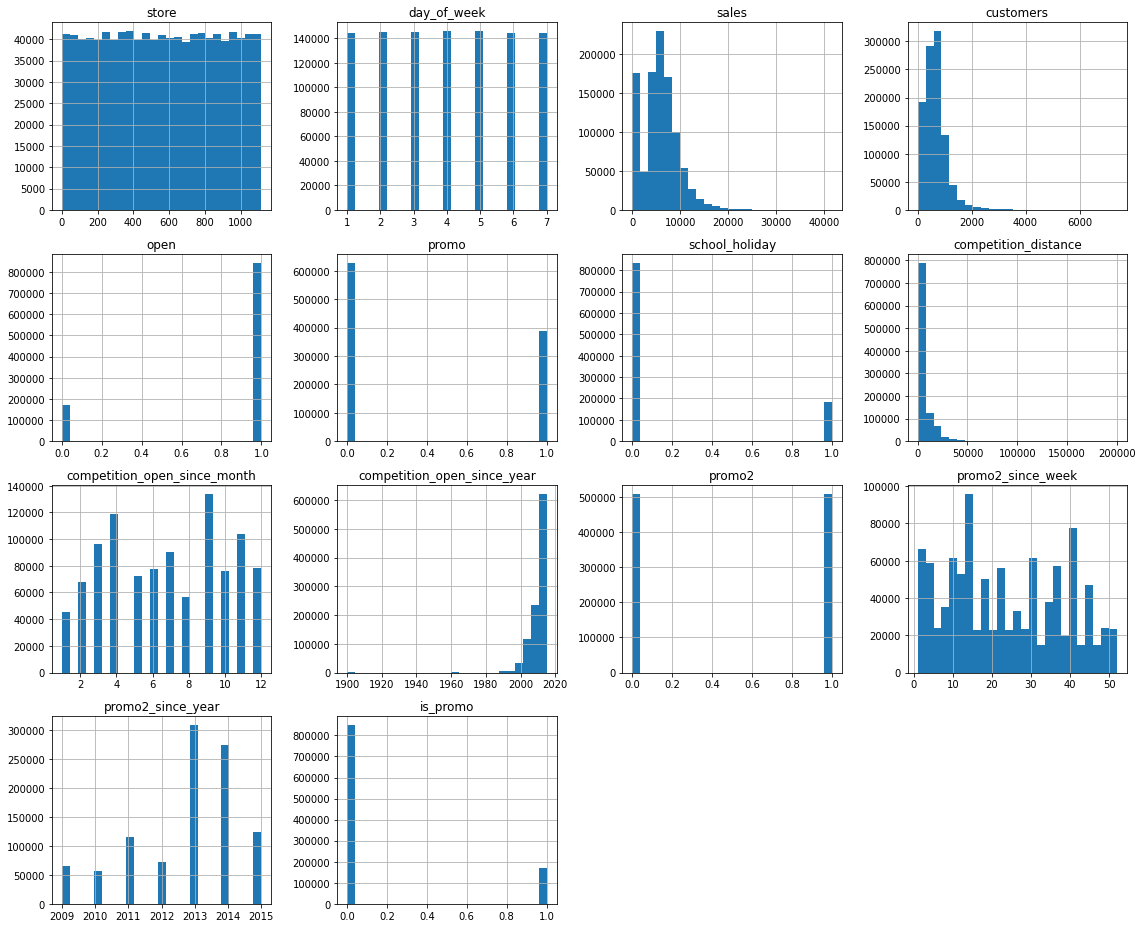

In [26]:
fig_dims = (16, 13)
num_attributes.hist(figsize=fig_dims, bins=25);
plt.tight_layout()

### 4.1.3 Variáveis Categoricas

In [27]:
df_aux = df4[df4['assortment'] == 'basic']['store'].sort_values().unique()
len(df_aux)
# 9 lojas assortment = extra
# 513 lojas Extended
# 593 lojas basic

593

#### State Holiday, Store Type, Assortment

C:\Users\emanu\anaconda3\envs\ds_em_producao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\emanu\anaconda3\envs\ds_em_producao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\emanu\anaconda3\envs\ds_em_producao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinte

<AxesSubplot:xlabel='sales', ylabel='Density'>

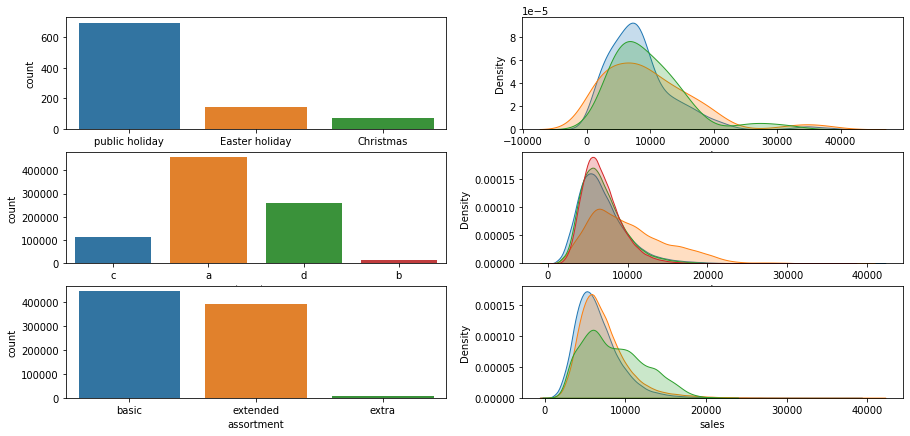

In [28]:
# State Holiday
fig_size = (15,7)
fig,ax = plt.subplots(figsize = fig_size)

plt.subplot(3, 2, 1)
holidays = df4[df4['state_holiday'] != 'regular day']
sns.countplot( holidays['state_holiday'] )

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public holiday']['sales'], label='public holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'Easter holiday']['sales'], label='Easter holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'Christmas']['sales'], label='Christmas', shade=True)

# Store Type
plt.subplot(3, 2, 3)
sns.countplot( df4['store_type'] )

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)

# Assortment
plt.subplot(3, 2, 5)
sns.countplot( df4['assortment'] )

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)

## 4.2 Análise Bivariada

## 4.3 Análise multivariada